In [1]:
import tensorflow as tf
import numpy as np
import os
import re
import dill
import base64
import requests
import PIL 
import matplotlib.pyplot as plt
import gc
import tarfile
import os.path

from PIL import Image
from matplotlib.pyplot import Figure
from shutil import rmtree
from bs4 import BeautifulSoup
from urllib.request import urlretrieve
from tensorflow.image import resize
from tensorflow.data import Dataset 
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize,array_to_img,\
    ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import EfficientNetB1, EfficientNetB2, EfficientNetB3,\
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.data.experimental import save, cardinality
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.backend import clear_session
from tensorflow.distribute import get_strategy
from tensorflow.keras.models import load_model
from itertools import chain

In [7]:
MAIN_STORAGE="./capstonedump"
PHOTOS_SOURCE=f"{MAIN_STORAGE}/photos"
LATENT_VECTORS_STORAGE=f"{MAIN_STORAGE}/latents"
TFMODELS_STORAGE=f"{MAIN_STORAGE}/tfmodels"
PLOTS_STORAGE=f"{MAIN_STORAGE}/plots"
LISTING_SOURCE=f"{MAIN_STORAGE}/listing-images"
CATEGORY="kitchen"
BATCH=(20, 30, 50)
IMG_SIZE={
    "EfficientNetB0":224,
    "EfficientNetB1":240,
    "EfficientNetB2":260,
    "EfficientNetB3":300,
    "EfficientNetB4":380,
    "EfficientNetB5":456,
    "EfficientNetB6":528,
    "EfficientNetB7":600, 
    "InceptionV3":299
} 
LATENT_EPOCHS=1
N_CLASSES=3
N_COLORS=3
STRATEGY=get_strategy() 
OPTIMIZATION_SUBDATASETS=("training", "validation")
MODEL_SPEC="EfficientNetB5"

In [ ]:
def unzip_imageset():
    if os.path.isdir("./capstonedump/photos"):
        ! rm -R ./capstonedump/photos
    ! tar -xf ./capstonedump/large-imageset.tar.gz -C ./capstonedump/
unzip_imageset()

## process jpg jpeg

### imgprep

```python
class ImgPrep: 
    def decode_base64(in_save, in_encription):
            with open(in_save, 'wb') as outfile_:
                stripped=re.sub('data:image/jpeg;base64,', '', in_encription)
                decoded=base64.b64decode((stripped))
                outfile_.write(decoded) 
            
    def decript_gstatic(in_save, in_gstatic):
        browser.get(in_gstatic)
        soup=BeautifulSoup(browser.page_source, 'lxml')
        encriptedimg=[img[attr]  
                      for attr in ['src', 'data-src']  
                      for img in soup.find_all('img', 
                                               {attr: True})]
        urlretrieve(encriptedimg[0] , in_save)

    def download(in_imglinks, in_category="lux-kitchen"):
        base64_save=f"./capstonedump/base64-{in_category}"+"-{}.jpeg"
        gstatic_save=f"./capstonedump/gstatic-{in_category}"+"-{}.jpg"

        [ImgPrep.decode_base64(base64_save.format(index), unit)
         if "data:image/jpeg;base64,/9j"  
         in unit 
         else urlretrieve(unit, gstatic_save.format(index))
         for index, unit 
         in enumerate(luxlinks)]

    def digitize(in_imgfiles):
        return [img_to_array(load_img(unit)) 
                for unit in in_imgfiles]

    def rescale(in_pixelstack, img_size = IMG_SIZE[0], in_save="./capstonedump/resized.pkd"):
        return [smart_resize(unit, size=(IMG_SIZE[0], IMG_SIZE[0])) 
                    for unit 
                    in digitized]
    
    def label_from_file(in_file):
        possession_=(re
                    .search(
                        "|".join(LABELS.keys()),
                        in_file) 
                    .group())
        return LABELS[possession_] 
```

#### first img

`imgfiles=os.listdir('./capstonedump/')`

`jpgpaths=["./capstonedump/"+file for file in os.listdir('./capstonedump/') if file.endswith('.jpg')]`

`jpgloaded=load_img(jpgpaths[0])`

`analog=img_to_array(jpgloaded)`

`rescaled=smart_resize(analog, size=(224, 224))`

`array_to_img(rescaled)`

#### tf preprocessor

Assume a set of jpgs and jpegs (w. labels)

Preprocess imgs via tf:
1. load pkd img links (base64 jpegs and gstatic jpg)
2. convert into arrays ($N \times K \times K$)
3. one hot encode labels

#### merge classes && make labels

```
['allsrc-luxurious-kitchen.pkd',
 'allsrc-dilapidated-kitchen.pkd',
 'allsrc-home-kitchen.pkd']
```

```python
[os.remove(f"./capstonedump/{unit}")
 for unit in os.listdir("./capstonedump/") 
 if any(map(unit.__contains__, ["jpg", "jpeg"]))]
```

#### arrayfy imgs put into labelled classes

```python
[os.mkdir(f"{DATASET_SAVEDIR}{i}") for i in range(N_CLASSES)]
[os.mkdir(f"{PHOTO_SAVEDIR}{i}/") for i in range(N_CLASSES)]
```

```python
links_in_classes=[(dill.load(open(f"{CORE_SAVEDIR}{file}", "rb")),  
                    ImgPrep.label_from_file(file))
                        for file in os.listdir(CORE_SAVEDIR) 
                        if file.startswith("allsrc")  
                            and file.endswith(".pkd")]
```

```python
[ImgPrep.decode_base64(f"{PHOTO_SAVEDIR}{label}/{index}.jpeg", unit)
    if "data:image/jpeg;base64,/9j" in unit
    else urlretrieve(unit, f"{PHOTO_SAVEDIR}{label}/{index}.jpg")
    for links, label in links_in_classes
    for index, unit in enumerate(links)]
```

```python
[np.save(f"{DATASET_SAVEDIR}{label}/{index}.npy",  
        img_to_array(load_img(f"{PHOTO_SAVEDIR}{label}/{file}")),
        allow_pickle=True)
    for label in os.listdir(f"{PHOTO_SAVEDIR}")
    for index, file in enumerate(os.listdir(f"{PHOTO_SAVEDIR}{label}"))]
```

```python 
[os.remove(f"{CORE_SAVEDIR}{file}") 
 for file in os.listdir(CORE_SAVEDIR) 
 if file.endswith(('.jpg', '.jpeg'))]
labels_and_images()
```

#### decoder

```python
class ImgDecoder:
    def make_diretories():
        [os.mkdir(f"{DATASET_SAVEDIR}{i}")  
         for i in range(N_CLASSES)]
        [os.mkdir(f"{PHOTO_SAVEDIR}{i}/") 
         for i in range(N_CLASSES)]
        
    def links_in_classes():
        return [(dill.load(open(f"{CORE_SAVEDIR}{file}",  
                                "rb")),  
                 ImgPrep.label_from_file(file))
                    for file  
                    in os.listdir(CORE_SAVEDIR) 
                    if file.startswith("allsrc")  
                        and file.endswith(".pkd")]
    
    def decode_from_links():
        [ImgPrep.decode_base64(f"{PHOTO_SAVEDIR}{label}/{index}.jpeg", unit)
            if "data:image/jpeg;base64,/9j" 
            in unit
            else urlretrieve(unit, f"{PHOTO_SAVEDIR}{label}/{index}.jpg")
            for links, label  
            in ImgDecoder.links_in_classes()
            for index, unit  
            in enumerate(links)]
    
    def run():
        ImgDecoder.make_diretories()
        ImgDecoder.decode_from_links()
```

### load images && tf reprocess

In [3]:
%%time
def split_factory(**KWARGS):
    return image_dataset_from_directory(
                KWARGS["image_source"], 
                labels="inferred", 
                label_mode="int",
                class_names=list(map(str,  
                                     range(N_CLASSES))),
                color_mode="rgb",
                image_size=(KWARGS['image_size'],  
                            KWARGS['image_size']),
                subset=KWARGS["subset"],
                shuffle=True,
                batch_size=KWARGS['batch_size'],
                seed=1,
                validation_split=0.20)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 6.91 µs


In [4]:
split={subset: 
           split_factory(image_source=PHOTOS_SOURCE,
                         subset=subset, 
                         image_size=IMG_SIZE[MODEL_SPEC], 
                         batch_size=BATCH[0]) 
       for subset  
       in OPTIMIZATION_SUBDATASETS} 

distributed={index: 
             STRATEGY.experimental_distribute_dataset(dataset)
             for index, dataset in split.items()}

Found 26720 files belonging to 3 classes.
Using 21376 files for training.
Found 26720 files belonging to 3 classes.
Using 5344 files for validation.


#### notes

```python
Found 2823 files belonging to 3 classes.
Using 2400 files for training.
Found 2823 files belonging to 3 classes.
Using 423 files for validation.
CPU times: user 309 ms, sys: 51.3 ms, total: 360 ms
Wall time: 316 ms
    
inceptionv3 ? b?
```
```python
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer
```

## transfer learning

In [8]:
%%time
def pretrained_factory(**KWARGS):
    clear_session()
    expert=EfficientNetB5(
                include_top=True, 
                input_shape=(KWARGS["img_size"],  
                             KWARGS["img_size"],  
                             N_COLORS))
    pretrained=tf.keras.Model([expert.input],
                   [expert.layers[-KWARGS["num_layers_to_exclude"]] 
                          .output])
    pretrained.trainable=False
    pipeline=Sequential()
    pipeline.add(RandomFlip('horizontal', 
                            seed=1,
                            input_shape=(KWARGS['img_size'], 
                                         KWARGS['img_size'], 
                                         N_COLORS)))
    pipeline.add(RandomRotation(KWARGS['rotation_factor'], 
                                seed=1))
    pipeline.add(RandomContrast(KWARGS['contrast_factor'], 
                                seed=1))
    pipeline.add(pretrained)
    pipeline.summary()
    return pipeline

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 9.54 µs


In [9]:
transfer_student=pretrained_factory(
                     img_size=IMG_SIZE[MODEL_SPEC],
                     num_layers_to_exclude=2,
                     rotation_factor=0.1,
                     contrast_factor=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 456, 456, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 456, 456, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 456, 456, 3)       0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              28513527  
Total params: 28,513,527
Trainable params: 0
Non-trainable params: 28,513,527
_________________________________________________________________


In [10]:
%%time
def clean_directories_in(in_dir, **KWARGS):
    if in_dir:
        rmtree(in_dir)
    os.mkdir(in_dir)
    [os.mkdir(f"{in_dir}/{subdirectory}")  
         for subdirectory 
         in KWARGS['subdir'] ]

def calculate_latents(in_distributed_dataset, 
                      in_pretrained_model, 
                      **KWARGS
                     ): 
    SAVEPATH_="{}/{}/vectors-per-step-{}.npy"
    with STRATEGY.scope():
        for subset, dataset in in_distributed_dataset.items():
            for _ in range(LATENT_EPOCHS):
                for index, bundle in enumerate(
                                         iter(
                                             dataset)):
                    try:
                        latent_per_step=(in_pretrained_model 
                                         .predict(
                                             tf.convert_to_tensor(bundle[0]), 
                                             verbose=0))
                        clear_session()
                        gc.collect()
                    except tf.errors.InvalidArgumentError: 
                        pass
                    with open(SAVEPATH_.format(KWARGS["latents_save_location"],
                                               subset, 
                                               index),  
                              "wb") \
                        as fout_:
                        np.save(fout_,
                                latent_per_step,
                                allow_pickle=True) 
                    del latent_per_step

def compress_latents(in_path, out_path):
    with tarfile.open(out_path, "w:gz") as tar_:
        tar_.add(in_path, 
                 arcname=os.path.basename(in_path))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


In [ ]:
%%time
clean_directories_in(LATENT_VECTORS_STORAGE, 
                     subdir=OPTIMIZATION_SUBDATASETS)

calculate_latents(distributed,
                  transfer_student,
                  latents_save_location=LATENT_VECTORS_STORAGE) 

In [ ]:
compress_latents(LATENT_VECTORS_STORAGE, f"{MAIN_STORAGE}/latents-large-{MODEL_SPEC}.tar.gz")

In [11]:
%%time
def load_latent_vectors(in_load_path, 
                        **KWARGS
                       ):
    unsorted=[(int(re.split("\-|\.", file)[-2]), 
               np.load(f'{in_load_path}/{file}'))
              for file 
              in os.listdir(in_load_path)]
    ordered=sorted(unsorted,  
                   key = lambda index_dataset: 
                             index_dataset[0])
    
    stacked=(np.vstack(
                [dataset  
                 for index, dataset  
                 in ordered]))
    return stacked 
def one_hot_labels(in_label_images):
    """
    :in_label_images: 
        BatchDataset: image arrays (batch, pixels, pixels, colors) 
            && labels
    """
    unpacked_=list(
                 chain(
                     *[labels 
                       for images, labels 
                       in in_label_images])) 
    return tf.one_hot(unpacked_,  
                      depth=N_CLASSES)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [12]:
%%time 
try:
    latents_and_labels
    del latents_and_labels
    gc.collect()
except NameError:
    pass 

latents_and_labels={subset:
                    (load_latent_vectors(f"{LATENT_VECTORS_STORAGE}/{subset}/"),
                     one_hot_labels(split[subset]))
                         for subset in OPTIMIZATION_SUBDATASETS}

CPU times: user 34.2 s, sys: 4.83 s, total: 39 s
Wall time: 57.4 s


In [13]:
def classifier_facotory(**KWARGS):
    classifier=Sequential()
    classifier.add(
        Dense(
            N_CLASSES, 
            name="softmax",
            activation="softmax",
            input_dim=KWARGS['input_dim']))

    classifier.compile(
        optimizer=SGD(lr=0.0001,  
                      momentum=1.,  
                      nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return classifier

In [15]:
%%time
CLASSIFICATION_EPOCHS=1_000

clear_session()
classifier=classifier_facotory(
               input_dim=latent_dimension)
history=(classifier 
         .fit( 
            latents_and_labels['training'][0],  
            latents_and_labels['training'][1], 
            validation_data=tuple( 
                                latents_and_labels["validation"]),
            epochs=CLASSIFICATION_EPOCHS, 
            batch_size=BATCH[0]))

Epoch 1/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.7541 - accuracy: 0.7455 - val_loss: 0.8062 - val_accuracy: 0.7893
Epoch 2/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.8343 - accuracy: 0.8075 - val_loss: 0.9023 - val_accuracy: 0.8073
Epoch 3/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.8031 - accuracy: 0.8043 - val_loss: 0.8648 - val_accuracy: 0.7979
Epoch 4/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.8214 - accuracy: 0.7965 - val_loss: 0.9104 - val_accuracy: 0.7891
Epoch 5/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.7678 - accuracy: 0.8082 - val_loss: 0.9144 - val_accuracy: 0.7904
Epoch 6/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.7927 - accuracy: 0.8082 - val_loss: 1.0478 - val_accuracy: 0.7667
Epoch 7/1000
1069/1069 [==============================] - 1s 1ms/step - loss: 0.7641 - accuracy: 0.8205 - val_loss: 0.9729 -

In [16]:
os.mkdir(f"{TFMODELS_STORAGE}/{MODEL_SPEC}")
classifier.save(f"{TFMODELS_STORAGE}/{MODEL_SPEC}")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./capstonedump/tfmodels/EfficientNetB5/assets


In [17]:
def plot_accuracies(in_train, 
                    in_val, 
                    **KWARGS):
    acc_over_epochs=plt.figure()
    acc_over_epochs.patch.set_facecolor('white')
    acc_over_epochs.patch.alpha=.7
    drawer=acc_over_epochs.add_subplot(111, xlabel="epochs", ylabel="accuracy")
    
    curves=[drawer.plot(history, label=subset)  
            for subset, history  
            in zip(OPTIMIZATION_SUBDATASETS, [in_train, in_val])]
    handles, labels=drawer.get_legend_handles_labels()
    plt.legend(handles, labels)
    if (save_dir_:=KWARGS["saveas"]):
        acc_over_epochs.savefig(save_dir_)
    return acc_over_epochs

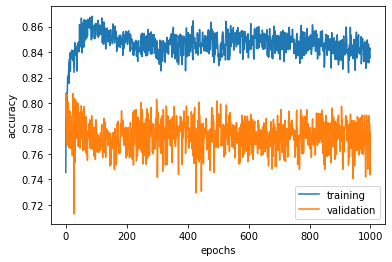

In [18]:
acc_over_epochs=plot_accuracies(
                    history.history["accuracy"], 
                    history.history["val_accuracy"],
                    saveas=f"{PLOTS_STORAGE}/temp2")
acc_over_epochs.show()

In [19]:
classifier_responses=np.argmax(
                            classifier 
                            .predict( 
                                latents_and_labels["validation"][0]), 
                            axis=-1)

(array([ 901.,    0.,    0.,    0.,    0., 2517.,    0.,    0.,    0.,
        1926.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

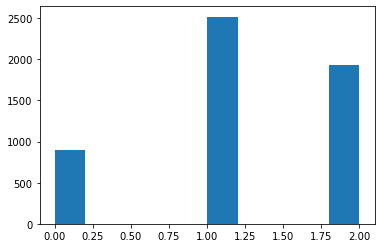

In [20]:
plt.hist(classifier_responses)

In [21]:
os.getcwd()

'/home/jovyan/jhshi'

## tag listing kitchens

```
(depricated)
Zillow profiles too hard to scrape
```

In [137]:
clear_session()
transfer_student=pretrained_factory(
                     img_size=IMG_SIZE[MODEL_SPEC],
                     num_layers_to_exclude=2,
                     rotation_factor=0.1,
                     contrast_factor=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 260, 260, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 260, 260, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 260, 260, 3)       0         
_________________________________________________________________
functional_1 (Functional)    (None, 1408)              7768569   
Total params: 7,768,569
Trainable params: 0
Non-trainable params: 7,768,569
_________________________________________________________________


In [138]:
address_images=[(file.split('.')[0], 
 tf.image.resize(
              img_to_array(
              Image.open(f"{LISTING_SOURCE}/{file}")),
              [IMG_SIZE[MODEL_SPEC], 
               IMG_SIZE[MODEL_SPEC]]))
 for file 
 in os.listdir(f"{LISTING_SOURCE}/")]

In [139]:
%%time
latent=transfer_student.predict(tf.stack([duo[1] for duo in address_images]), verbose=1) 

1/1 [==============================] - 0s 1ms/step
CPU times: user 4.51 s, sys: 232 ms, total: 4.74 s
Wall time: 2.45 s


In [140]:
with open(f"{MAIN_STORAGE}/latents-listings-and-addresses-{MODEL_SPEC}.pkd", "wb") as writefile:
    dill.dump(
        ([duo[0] for duo in address_images],
         latent),
        writefile)

In [141]:
classifier=classifier_facotory(input_dim=latent.shape[1])

In [142]:
latent.shape[1]

1408

In [134]:
classifier=load_model(TFMODELS_STORAGE)

In [122]:
classifier.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1408),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'softmax_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'softmax',
    'trainable': True,
    'batch_input_shape': (None, 1408),
    'dtype': 'float32',
    'units': 3,
    'activation': 'softmax',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}}]}

In [150]:
model_predictions=np.argmax(classifier.predict(tf.convert_to_tensor(latent)),
                            axis=1)

In [151]:
address_ratings={k:v 
                 for k,v in zip([duo[0] 
                                 for duo in address_images], model_predictions)}

In [152]:
address_ratings

{'1326-Diamond-St-kitchen': 2,
 '635-Joost-Ave-kitchen': 2,
 '1933-B-Jones-St-kitchen': 2,
 '8420-Birch-St-kitchen': 2,
 '62-Natick-St-kitchen': 2,
 '6424-Foothill-Blvd-kitchen': 2,
 '851-34th-Ave-kitchen': 2,
 '708-Long-Bridge-St-APT-110-kitchen': 2,
 '101-Upper-Ter-kitchen': 2,
 '1311-Guerrero-St-APT-1-kitchen': 1,
 '815-Pacheco-St-kitchen': 0,
 '1238-Sutter-St-#501-kitchen': 2,
 '181-Lucky-St-kitchen': 2,
 '1370-Quesada-Ave-kitchen': 2,
 '353-San-Jose-Ave-kitchen': 2}